In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import sys

import numpy as np
import torch.utils.data as data


class PalindromeDataset(data.Dataset):

    def __init__(self, seq_length):
        self.seq_length = seq_length


    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)

        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length/2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        # print(np.concatenate((left, right)).shape)
        return np.concatenate((left, right))

In [27]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

class VanillaRNN(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim, batch_size):
        super(VanillaRNN, self).__init__()
        # Initialization here ...
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.linear_x = nn.Linear(input_dim, hidden_dim)
        # print("linear_x: ", input_dim, hidden_dim)
        self.linear_h = nn.Linear(hidden_dim, input_dim)
        self.tanh = nn.Tanh()
        self.linear_y = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax()


    def forward(self, x):
        # Implementation here ...
        h = torch.zeros((self.batch_size, self.hidden_dim))
        y = None
        for i in range(self.seq_length):
            # print("x: ", x[i].size())
            sample = torch.reshape(x[i], (self.batch_size, 1))
            x_output = self.linear_x(sample)
            # print("x_output: ", (x_output))
            h_output = self.linear_h(h)
            # print("h_output: ", h_output)
            tanh_input = x_output + h_output
            # print("tanh_input: ", tanh_input)
            h = self.tanh(tanh_input)
            # print("h: ", h)
            if i == self.seq_length - 1:
                y_input = self.linear_y(h)
                y = self.softmax(y_input)
        return y


        
    # add more methods here if needed


D:\Workspace\pycharm\dl_project2_task3\vanilla_rnn.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.softmax(y_input)
D:\anaconda\lib\site-packages\ipykernel_launcher.py:53: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


画图
Done training.
finish


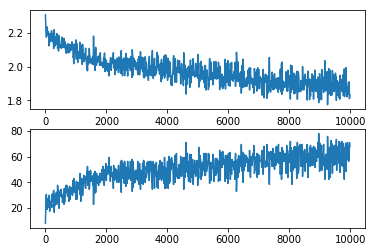

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

EVALUATE_STEP = 10

import matplotlib.pyplot as plt
import argparse
import time
import numpy as np
from operator import itemgetter

import torch
from torch import nn
from torch.utils.data import DataLoader

from dataset import PalindromeDataset
from vanilla_rnn import VanillaRNN

def train(config):
    # Initialize the model that we are going to use
    model = VanillaRNN(config.input_length, config.input_dim, config.num_hidden, config.num_classes, config.batch_size)  # fixme

    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(config.input_length+1)

    data_loader = DataLoader(dataset, config.batch_size, num_workers=1)

    # Setup the loss and optimizer
    criterion = nn.CrossEntropyLoss()   # fixme
    optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)  # fixme

    x_axis = list()
    loss_list = list()
    accuracys = list()

    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        # Add more code here ...
        hit = 0
        n, dim = batch_inputs.size()
        batch_inputs_T = torch.transpose(batch_inputs, 0, 1)
        # print(batch_inputs_T.size())
        y_hat_oh = model.forward(batch_inputs_T)
        for i in range(n):
            y_pre, _ = max(enumerate(y_hat_oh[i]), key=itemgetter(1))
            y = batch_targets[i].item()
            # print(y_pre, y)
            if y_pre == y:
                hit += 1
        # print("/////////")

        # the following line is to deal with exploding gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config.max_norm)

        # Add more code here ...
        loss = criterion(y_hat_oh, batch_targets)   # fixme
        accuracy = hit / n * 100  # fixme

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % EVALUATE_STEP == 0:
            x_axis.append(step)
            loss_list.append(loss.item())
            accuracys.append(accuracy)

        if step == config.train_steps - 1:
            print("画图")
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            fig = plt.figure()
            loss_fig = plt.subplot(2, 1 ,1)
            loss_fig.plot(x_axis, loss_list)
            accuracys_fig = plt.subplot(2, 1 ,2)
            accuracys_fig.plot(x_axis, accuracys)
            break
    print('Done training.')

if __name__ == "__main__":

    # Parse training configuration
    parser = argparse.ArgumentParser()

    # Model params
    parser.add_argument('--input_length', type=int, default=5, help='Length of an input sequence')
    parser.add_argument('--input_dim', type=int, default=1, help='Dimensionality of input sequence')
    parser.add_argument('--num_classes', type=int, default=10, help='Dimensionality of output sequence')
    parser.add_argument('--num_hidden', type=int, default=128, help='Number of hidden units in the model')
    parser.add_argument('--batch_size', type=int, default=128, help='Number of examples to process in a batch')
    parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--train_steps', type=int, default=10000, help='Number of training steps')
    parser.add_argument('--max_norm', type=float, default=10.0)

    config = parser.parse_args(args=list())
    # Train the model
    train(config)
    print("finish")

The first figure shows the loss.

The second figure shows the accuracy. 

Both of them are fluctuating, and the accuracy can not get the 'perfect performance'. 
Because the RNN training and prediction use same data set, don't like other mlp has separate train set and prediciton set.
And the RNN stucture is another reason. 

All the parameters are default.

